
本文参考中国银河证券研报《多因子系列: 多因子模型体系之因子组合的确定》，感谢分析师 黎鹏 在研报中提供的思路和方法，以下的内容我们通过数据和代码尝试进行了分析例证。  

<b>研究目的：</b>  

根据研报分析，专注于对多因子框架进行研究，本报告完成模型的第一步: 因子组合的确定。从分类的角度看，因子可认为是用于分类的标签。在股票市场中，股票代码是最细分的分类。多因子模型的一个主要作用是简化计算，因为如果用较少的共同因子来代替股票的各种特征，则可以将股票这个最细分的分类用少数的因子代替，从而大大降低计算的复杂度。但是因子的选择一直是个难点，因为基础因子的个数很多，算上衍生因子复杂度更是上升。为了降低构建因子组合的难度，本文认为可以尝试从基准的特征出发来确定因子。因为从股票组合管理的角度来看，因子最大的作用在于风险描述继而对冲，从而获得 Alpha收益。所以基准明显的特征应该是基准的明显风险点，应该首先得到关注。

<b>研究内容：</b>  

（1）首先，从基准的角度获取较为通用的因子。考虑到常见基准和是否有对应期货两方面因素，本文的基础基准设定为上证 50（IH），沪深 300（IF）和中证 500（IC），考虑到这三个基准的编制方式以及个股的通用性质，本文对以下 8 个因子进行研究：市值、股本、roe、净利润增长率（成长性因子）、PE（价值）、换手率、EPS 以及成交量。  
（2）根据因子在指数成分股中的暴露分析，从基准的角度看，因子是否通用，是否能代表基准明显的特征；  
（3）分析因子之间的相关性，避免相关性过高的因子进入因子组合，相关性过高的因子对于线性模型而言，往往导致模型出现较大误差，使得模型的预测能力下降；  
（4）通过研究因子 IC，分析因子解释力度是否较强，判断因子对个股未来收益的预测能力。

<b>研究结论：</b>  

组合的评判标准分为三点：因子暴露度、因子相关强度和因子选个股能力，相关结论如下：  
（1） 三大股指的市值和股本因子的偏离度均是最高的。中等偏离度的因子包括，换手率、ROE、PE、EPS 因子。偏离度最小的是净利润增长率因子。  
（2） 相关强度最低的组合为净利润增长率和成交量，换手率和 EPS，ROE 和换手率，股本和换手率。  
（3） 除了换手率因子较强，净利润增长率较弱之外，其他因子的选股能力区别不大。  
综合选择暴露度高、相关强度低和选股能力强的因子，股本和换手率作为因子组合较为合适。

**注:** 相关研报已上传为附件,文末可以下载 

# 1 数据获取

## 1.1 日期列表获取

研报以日为频率对不同风格的因子进行分析，但是由于研究环境内存限制，全市场日频数据量较多，无法保存并进行处理，因此本文考虑以周为频率对不同风格因子进行分析，每周的日期列表获取方式具体如下所示。  
输入参数分别为 peroid、start_date 和 end_date，其中 peroid 进行周期选择，可选周期为周(W)、月(M)和季(Q)，start_date 和end_date 分别为开始日期和结束日期。  
本文取 peroid 为 W，函数返回值为对应的周末日期。本文选取开始日期为 2014.1.1，结束日期为 2019.1.1。

In [1]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/21612
# 标题：多因子系列之多因子模型体系之因子组合的确定

from jqdata import *
import datetime
import pandas as pd
import numpy as np
from six import StringIO
import warnings
import time
import pickle
from jqfactor import winsorize_med
from jqfactor import neutralize
from jqfactor import standardlize
import statsmodels.api as sm
warnings.filterwarnings("ignore")
matplotlib.rcParams['axes.unicode_minus']=False


In [2]:
#获取指定周期的日期列表 'W、M、Q'
def get_period_date(peroid,start_date, end_date):
    #设定转换周期period_type  转换为周是'W',月'M',季度线'Q',五分钟'5min',12天'12D'
    stock_data = get_price('000001.XSHE',start_date,end_date,'daily',fields=['close'])
    #记录每个周期中最后一个交易日
    stock_data['date']=stock_data.index
    #进行转换，周线的每个变量都等于那一周中最后一个交易日的变量值
    period_stock_data=stock_data.resample(peroid,how='last')
    date=period_stock_data.index
    pydate_array = date.to_pydatetime()
    date_only_array = np.vectorize(lambda s: s.strftime('%Y-%m-%d'))(pydate_array )
    date_only_series = pd.Series(date_only_array)
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    start_date=start_date-datetime.timedelta(days=1)
    start_date = start_date.strftime("%Y-%m-%d")
    date_list=date_only_series.values.tolist()
    date_list.insert(0,start_date)
    TradeDate = []
    for i in date_list:
        temp = list(get_trade_days(end_date=i, count=1))[0]
        TradeDate.append(str(temp))
    return TradeDate
np.array(get_period_date('W', '2018-01-01', '2019-01-01'))


array([2017-12-29, 2018-01-05, 2018-01-12, 2018-01-19, 2018-01-26,
       2018-02-02, 2018-02-09, 2018-02-14, 2018-02-23, 2018-03-02,
       2018-03-09, 2018-03-16, 2018-03-23, 2018-03-30, 2018-04-04,
       2018-04-13, 2018-04-20, 2018-04-27, 2018-05-04, 2018-05-11,
       2018-05-18, 2018-05-25, 2018-06-01, 2018-06-08, 2018-06-15,
       2018-06-22, 2018-06-29, 2018-07-06, 2018-07-13, 2018-07-20,
       2018-07-27, 2018-08-03, 2018-08-10, 2018-08-17, 2018-08-24,
       2018-08-31, 2018-09-07, 2018-09-14, 2018-09-21, 2018-09-28,
       2018-09-28, 2018-10-12, 2018-10-19, 2018-10-26, 2018-11-02,
       2018-11-09, 2018-11-16, 2018-11-23, 2018-11-30, 2018-12-07,
       2018-12-14, 2018-12-21, 2018-12-28], 
      dtype='|S10')

上述代码实现的功能为获取开始时间为 2018.1.1，结束日期为 2019.1.1 的每周的可交易日期列表。利用该函数可实现对任意时间区间的每周的可交易日期列表。

## 1.2 数据获取

为了形成最初的因子组合，我们可通过对基准编制规则进行解读，从直观上对基准的特征有所了解。然后形成逻辑且具有经济意义的初步因子组合列表。下表我们分别展示了上证 50 (000016)，沪深 300(000300)和中证 500(000905)指数的样本股编制规则：   

| 指数名称      | 股票池           | 股票个数  |加权方法  |选股条件  |对应因子  |
| ------------- |:-------------:| -----:| -----:| -----:| -----:|
| 上证 50       | 上证180     | 50     | 派许加权 + 调整股本     |规模、流动性     |流通市值、成交金额     |
| 沪深 300      | 全 A 股      |   300 |派许加权 + 调整股本     |规模     |日均总市值     |
| 中证 500      | 全 A 股扣除市值最大的 300 只      |    500 |派许加权 + 调整股本     |规模     |日均总市值     |

从指数样本股选取标准上看，市值是重点考虑的方面。从加权方式上看股本需要加入初步的因子库。考虑到个股的通用性质，初步加入了 roe、 净利润增长率（成长性因子）、PE（价值）、换手率等因子。具体因子如下表所示：  

| 因子名称      | 计算方法           | 因子描述  |
| ------------- |:-------------:| -----:|
| 市值       | 总市值 = 个股当日股价 $\times$ 当日总股本  | 规模相关，信息包含股本和股价     | 
| 股本      | 报表科目，详见会计报表     |  规模相关 |
| EPS     | 当期净利润 / 普通股加权平均   |  业绩相关 |
| Roe      | 归属母公司股东的净利润占比 $\times$ 销售净利率 $\times$ 资产周转率 $\times$ 权益乘数     |  盈利能力相关 |
| 净利润增长率   | (本期 -上年同期调整数 ) / ABS上年同期调整数 $\times$ 100%   |  成长能力相关 |
| PE   | 市值 / 当期净利润   |  估值因子 |
| 换手率   | 成交量 / 总股数   |  行情相关 |

In [3]:
start = time.clock()
begin_date = '2014-01-01'
end_date = '2019-01-01'
TradeDate = get_period_date('W',begin_date, end_date)
factorData = {}
for date in TradeDate:
    stockList = get_index_stocks('000002.XSHG',date) + get_index_stocks('399107.XSHE',date)
    df_volume = get_price(stockList, count = 1, end_date = date, frequency='1d', fields=['volume'])['volume']
    df_fund = get_fundamentals(query(valuation.code, valuation.turnover_ratio, valuation.pe_ratio, valuation.market_cap, \
                                    valuation.capitalization, indicator.eps, indicator.roe, indicator.inc_net_profit_year_on_year).filter(valuation.code.in_(stockList)), date = date)       

    df_fund = df_fund.set_index(['code'])
    df_fund['volume'] = df_volume.T
    factorData[date] = df_fund
elapsed = (time.clock() - start)
print("Time used:",elapsed)


('Time used:', 302.09024600000004)


# 2 因子暴露分析

我们选取了估值、成长、行情等相关的风格因子。因为这些因子不但市场关注度较高，而且是 Barra 多因子框架中几个重要的风险因子。为了判断上证 50，沪深 300 和 中证 500 在历史上各因子的暴露情况，我们以周为频率测算因子相对于全市场的偏离程度。考虑可比性和统一标尺，我们使用的数据为因子当日的排序。计算步骤如下:   
（1） 将每日因子按 照从大到小排序；  
（2） 从中取出属于某一指数的成份股，计算因子的排序平均值；  
（3） 暴露度= (指数因子排序平均值 - 当日全市场排序中间值)/当日股票总个数


In [4]:
import matplotlib.pyplot as plt

Fields = ['turnover_ratio', 'pe_ratio', 'market_cap', 'capitalization', 'eps', 'roe', 'inc_net_profit_year_on_year', 'volume']
def getExplore(index):
    if index == 'SH50':
        index = '000016.XSHG'
    if index == 'HS300':
        index = '000300.XSHG'
    if index == 'ZZ500':
        index = '000905.XSHG'
    explore = pd.DataFrame(index = TradeDate)
    for i in Fields:
        tempExplore = []
        for date in TradeDate:
            stockList = get_index_stocks(index, date)
            temp = factorData[date][[i]]
            temp = temp.sort([i],ascending = False)
            temp['rank'] = range(len(temp)+1, 1, -1)
            # 获取指数的排序均值
            tempExplore.append((temp.loc[stockList,'rank'].mean() - len(temp) / 2) / len(temp))
        explore[i] = tempExplore
    return explore
result_SH50 = []
result_HS300 = []
result_ZZ500 = []
explore1 = getExplore('SH50')
explore2 = getExplore('HS300')
explore3 = getExplore('ZZ500')
for i in Fields:
    result_SH50.append(explore1[i].mean())
    result_HS300.append(explore2[i].mean())
    result_ZZ500.append(explore3[i].mean())

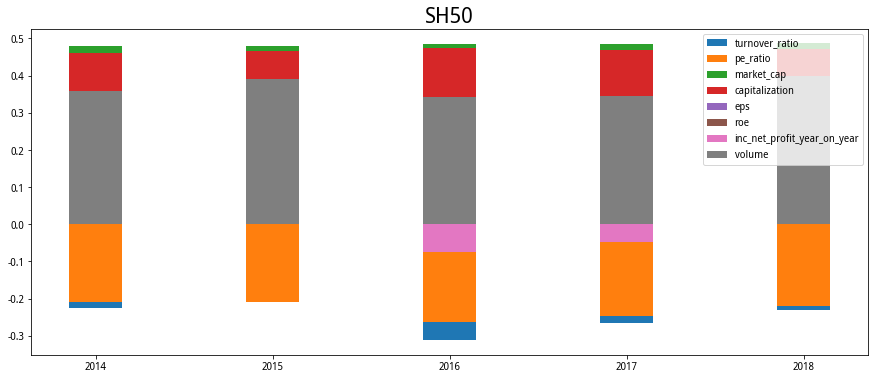

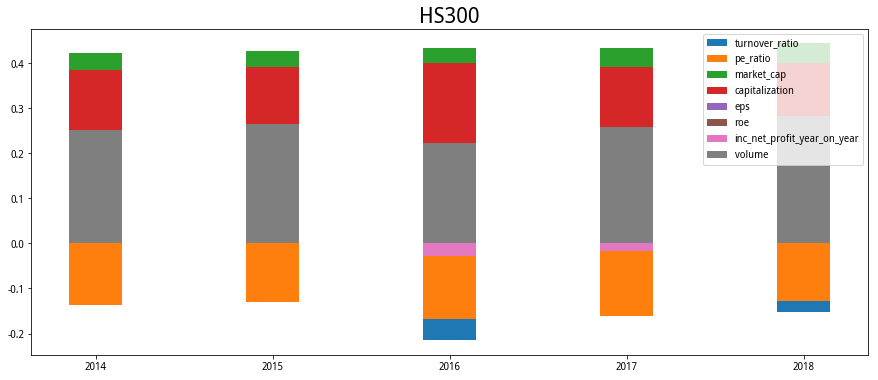

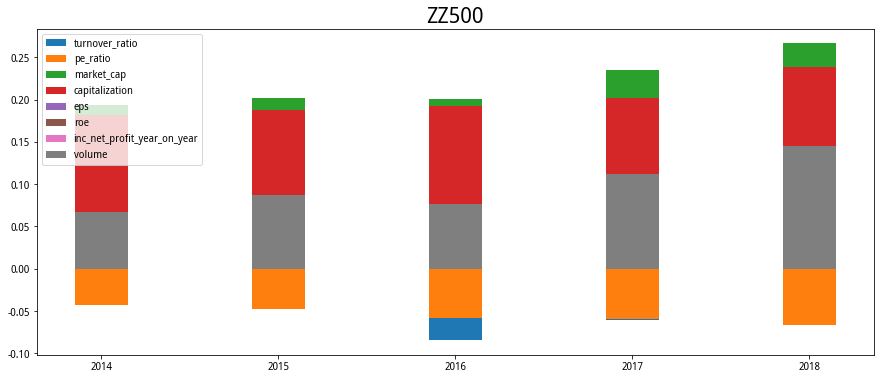

In [5]:
Year= ['2014', '2015', '2016', '2017', '2018']
Fields = ['turnover_ratio', 'pe_ratio', 'market_cap', 'capitalization', 'eps', 'roe', 'inc_net_profit_year_on_year', 'volume']
total1 = pd.DataFrame()
total2 = pd.DataFrame()
total3 = pd.DataFrame()
for i in range(len(Year)):
    total1[Year[i]] = explore1.iloc[i*len(explore1)/5:(i+1)*len(explore1)/5,:].mean()
    total2[Year[i]] = explore2.iloc[i*len(explore1)/5:(i+1)*len(explore1)/5,:].mean()
    total3[Year[i]] = explore3.iloc[i*len(explore1)/5:(i+1)*len(explore1)/5,:].mean()
x = np.array(range(len(Year)))
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
for i in Fields:
    plt.bar(x, total1.loc[i], 0.3, label = i)
plt.xticks(range(len(Year)), Year)
ax.set_title("SH50", fontsize=21)
# 添加图例
plt.legend()
plt.show()
x = np.array(range(len(Year)))
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
for i in Fields:
    plt.bar(x, total2.loc[i], 0.3, label = i)
plt.xticks(range(len(Year)), Year)
ax.set_title("HS300", fontsize=21)
# 添加图例
plt.legend()
plt.show()
x = np.array(range(len(Year)))
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
for i in Fields:
    plt.bar(x, total3.loc[i], 0.3, label = i)
plt.xticks(range(len(Year)), Year)
ax.set_title("ZZ500", fontsize=21)
# 添加图例
plt.legend()
plt.show()


上图展示的结果为分年度因子暴露，横坐标是年度，颜色点代表当年的因子暴露情况。由上图可以看出：  
（1）市值和股本因子的偏离度在每一年均是最高的。上证 50 市值和股本的偏离度稳定 50%，沪深300的偏离度稳定在 40%，而中证 500 的偏离度从最初 20% 左右逐年提升至 25%；   
（2）净利润增长率因子在每一年都接近 0，可见该因子对三大股指的有效性较低。

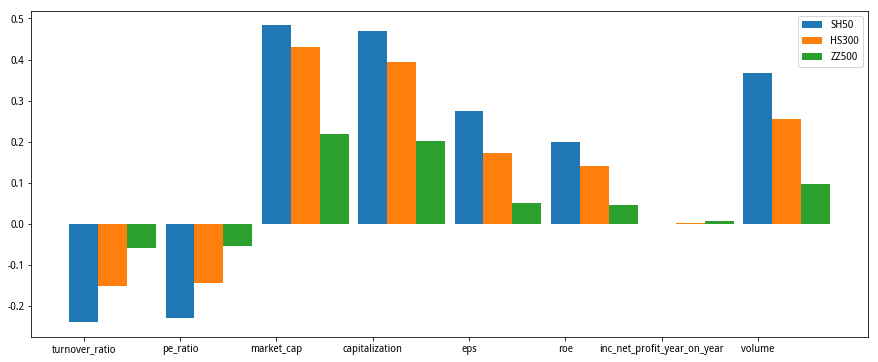

In [6]:
fig = plt.figure(figsize=(15,6))
bar_width = 0.3
x = np.array(range(len(result_SH50)))
plt.bar(x, result_SH50, bar_width, label = 'SH50')
plt.bar(x+bar_width, result_HS300, bar_width, label = 'HS300')
plt.bar(x+bar_width+bar_width, result_ZZ500, bar_width, label = 'ZZ500')
plt.xticks(range(len(result_SH50)), Fields)
# 添加图例
plt.legend()
plt.show()


以上分别统计了三大股指的因子暴露情况，统计了各个因子在 2014 年至 2019 年的平均暴露。从整体上来看:  
（1）市值和股本因子的偏离度均是最高的。上证 50 市值和股本的偏离度稳定在 50% 左右，沪深 300 的偏离度稳定在 40% 左右，而中证 500 的在 20% 左右。
（2）中等偏离度的因子包括，换手率、ROE、PE、EPS 因子。这些因子在上证 50 和沪深 300 指数的偏离度在 20% - 30% 左右，然而中证 500 只有 10%以下。  
（3） 偏离度最小的是净利润增长率因子，在三大指数中，净利润增长率的偏离度几乎为 0。也就是说大市值和小市值个股在成长性方面看，差异不大。  
综上所述，因为三大股指在净利润增长率因子上的暴露度几乎为 0，我们可以考虑将该因子移出风险因子库。  
但是除了需要考虑因子的暴露之外，我们还需要计算因子之间的相关性。将相关性较高的因子区分开来，可以降低因子共线性风险并且减少因子个数。接下来我们对这几个因子的相关性进行分析。

# 3 因子相关性分析

## 3.1 相关性平均值

In [7]:
def getCorr(index):
    if index == 'SH50':
        index = '000016.XSHG'
    if index == 'HS300':
        index = '000300.XSHG'
    if index == 'ZZ500':
        index = '000905.XSHG'
    corr = {}
    for date in TradeDate:
        stockList = get_index_stocks(index, date)
        temp = factorData[date].loc[stockList,:]
        corr[date] = temp.corr()
    corr = pd.Panel.from_dict(corr)
    return corr
corr_SH50 = getCorr('SH50')
corr_HS300 = getCorr('HS300')
corr_ZZ500 = getCorr('ZZ500')


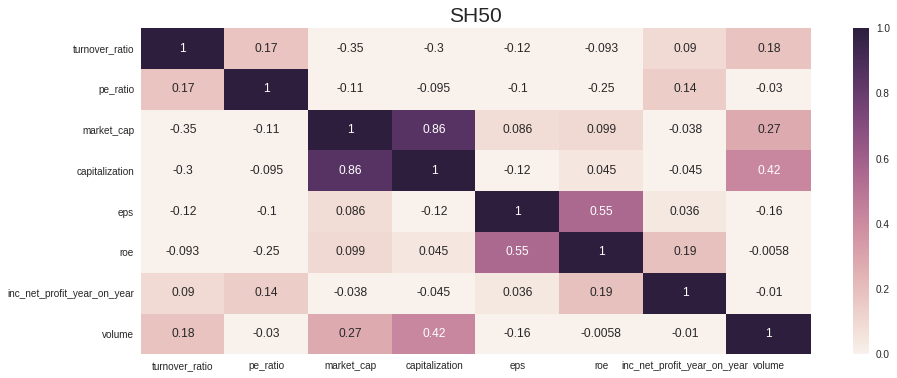

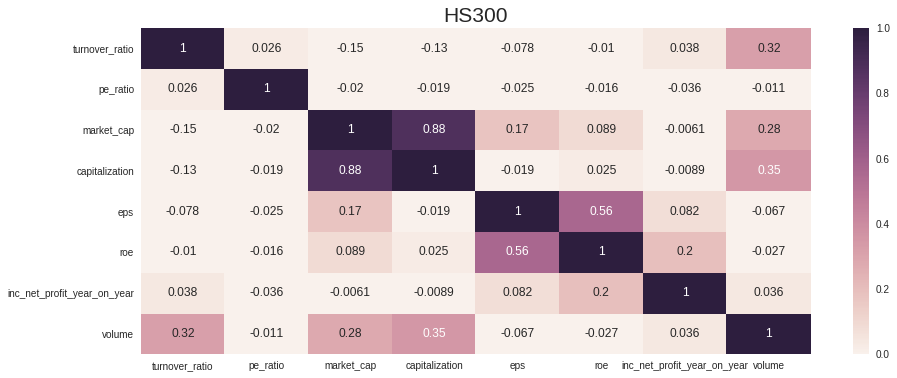

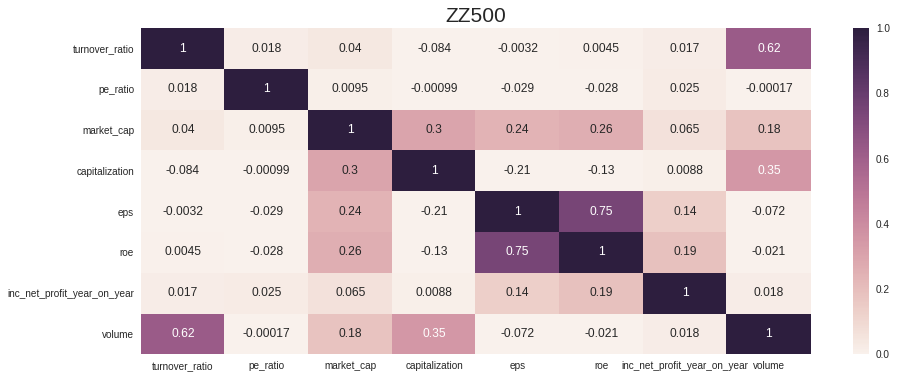

In [8]:
import seaborn as sns
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
sns.heatmap(corr_SH50.mean(axis = 0), annot=True, vmax=1, vmin = 0)
ax.set_title("SH50", fontsize=21)
fig.show()
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
sns.heatmap(corr_HS300.mean(axis = 0), annot=True, vmax=1, vmin = 0)
ax.set_title("HS300", fontsize=21)
fig.show()
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
sns.heatmap(corr_ZZ500.mean(axis = 0), annot=True, vmax=1, vmin = 0)
ax.set_title("ZZ500", fontsize=21)
fig.show()


上表分别展示了各因子在三大股指中的相关性，测试时间段为 2014 年至 2019 年共 5 年 时间。根据上表的展示结果，得出结论如下所示：  
（1）从上证 50 指数成份股的角度看，相关性最高的因子为股本和成交量，达到了 0.86，其次为 eps 和 roe，为0.55；  
（2）从沪深 300 成份股的角度看，和上证 50 相似，但换手率和市值的相关性降低；    
（3）从中证 500 成份股的角度看，和其他两个指数相似，换手率和市值的相关性进一步降低。   
以上为相关性的平均值，为了考虑相关性的稳定情况，下表分别展示了各因子在三大股指中的相关性标准差，标准差越小，相关性越稳定。

## 3.2 相关性标准差


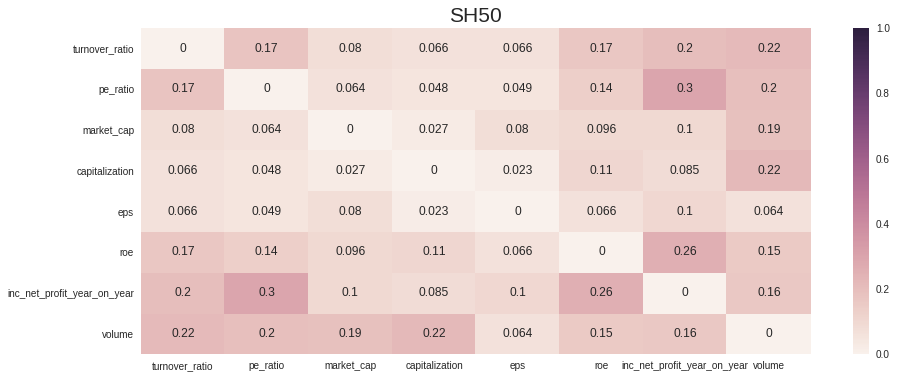

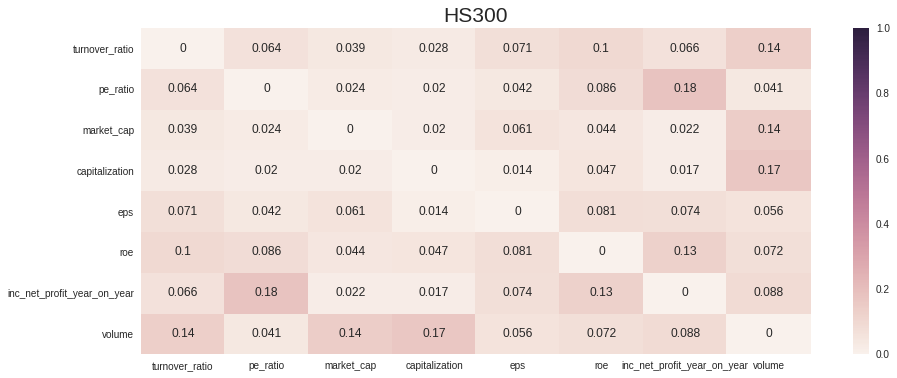

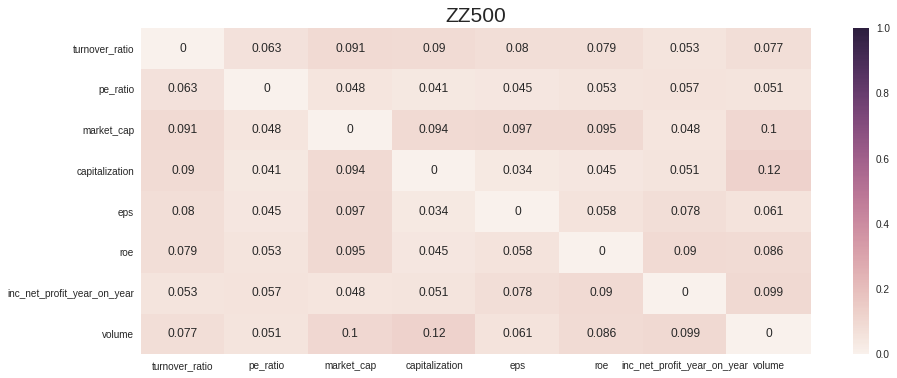

In [9]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
sns.heatmap(corr_SH50.std(axis = 0), annot=True, vmax=1, vmin = 0)
ax.set_title("SH50", fontsize=21)
fig.show()
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
sns.heatmap(corr_HS300.std(axis = 0), annot=True, vmax=1, vmin = 0)
ax.set_title("HS300", fontsize=21)
fig.show()
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
sns.heatmap(corr_ZZ500.std(axis = 0), annot=True, vmax=1, vmin = 0)
ax.set_title("ZZ500", fontsize=21)
fig.show()


上表分别展示了各因子在三大股指中的相关性标准差，测试时间段为 2014 年至 2019 年共 5 年 时间。根据上表的展示结果，得出结论如下所示：  
（1）从上证 50 指数成份股的角度看，波动性最高的为净利润增长率和 PE，其次是净利润增长率和 ROE；  
（2）从沪深 300 成份股的角度看，和上证 50 相似，但波动性降低；  
（3）从中证 500 成份股的角度看，和其他两个指数相似，但波动性进一步降低。  


## 3.3 相关强度


以上部分展示了相关性的均值以及标准差，通过两者相除我们能得到判断因子相关性强弱的指标。其绝对值越大，说明它的相关性越强。  
计算公式为:   
<center>$𝑥 = mean(Corr) / std(corr)$ </center>

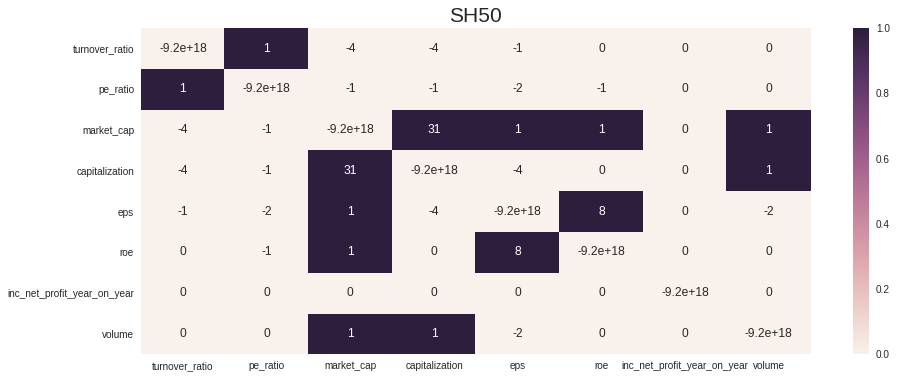

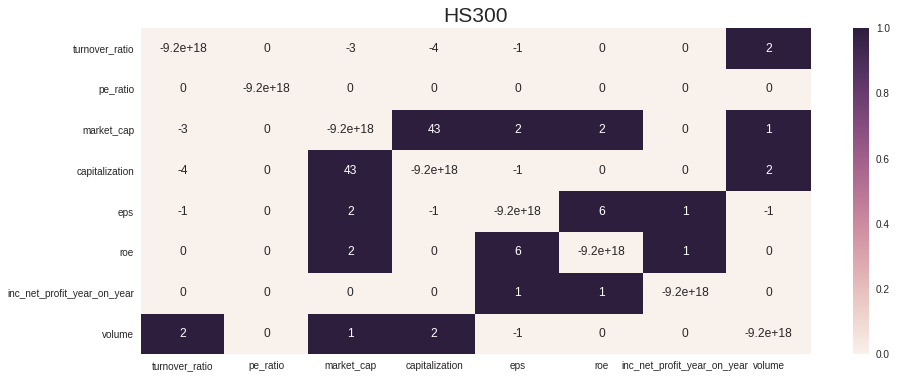

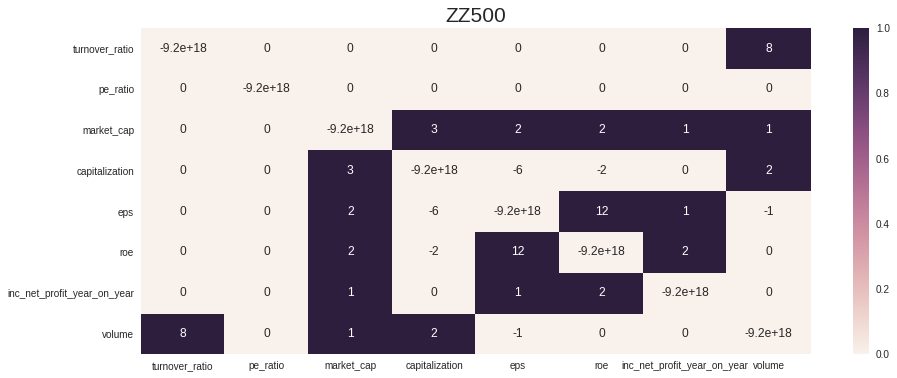

In [10]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
sns.heatmap((corr_SH50.mean(axis = 0) / corr_SH50.std(axis = 0)).astype(int), annot=True, vmax=1, vmin = 0)
ax.set_title("SH50", fontsize=21)
fig.show()
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
sns.heatmap((corr_HS300.mean(axis = 0) / corr_HS300.std(axis = 0)).astype(int), annot=True, vmax=1, vmin = 0)
ax.set_title("HS300", fontsize=21)
fig.show()
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
sns.heatmap((corr_ZZ500.mean(axis = 0) / corr_ZZ500.std(axis = 0)).astype(int), annot=True, vmax=1, vmin = 0)
ax.set_title("ZZ500", fontsize=21)
fig.show()

从相关强度表中可以得出以下结论：  
（1）对于这三个指数，ROE 和 EPS 因子是有明显稳定的相关性的，股本与市值也有着较强的相关性;  
（2）其他因子之间的相关强度的绝对值基本在 1-5 之间;  
（3）相关强度最低的组合为净利润增长率和成交量，换手率和 EPS， ROE 和换手率，股本和换手率等。

# 4 因子 IC 分析

除了考虑因子的相关性，因子的选股能力是我们第三个评判标准。我们通过因子的周 IC 值来选择解释力度较高的因子，判别步骤如下所示:  
（1）选出股票池，比如从全市场中选出属于上证 50 成份股的个股；  
（2）因子按照从大到小排序；  
（3）后一日收益率按照从大到小排序；  
（4）计算两个排序之间的相关性，即计算Rank IC。

## 4.1 IC 均值分析

In [11]:
import scipy.stats as st
def factor_IC_analysis(factorData, index):  
    if index == 'SH50':
        index = '000016.XSHG'
    if index == 'HS300':
        index = '000300.XSHG'
    if index == 'ZZ500':
        index = '000905.XSHG'
    if index == 'A':
        index = None
    IC = []
    for date in TradeDate[:-1]:
        if index:
            #取股票池
            stockList = get_index_stocks(index, date)
        else:
            stockList = list(factorData[date].index)
        #获取横截面收益率
        df_close=get_price(stockList, date, TradeDate[TradeDate.index(date)+1], 'daily', ['close'])
        if df_close.empty:
            continue
        df_pchg=df_close['close'].iloc[-1,:]/df_close['close'].iloc[0,:]-1
        R_T = pd.DataFrame()
        R_T['pchg']=df_pchg
        IC_Field = []
        for i in Fields:
            #获取因子数据
            factor_data = factorData[date].loc[stockList, i]
            R_T['factor'] = factor_data
            R_T = R_T.dropna()
            IC_Field.append(st.pearsonr(R_T.pchg.rank(), R_T['factor'].rank())[0])
        IC.append(IC_Field)
    result = pd.DataFrame(index = TradeDate[:-1], columns = Fields, data = IC)
    result = result.dropna(how = 'all')
    return result
IC_SH50 = factor_IC_analysis(factorData, 'SH50')
IC_HS300 = factor_IC_analysis(factorData, 'HS300')
IC_ZZ500 = factor_IC_analysis(factorData, 'ZZ500')
IC_A = factor_IC_analysis(factorData, 'A')


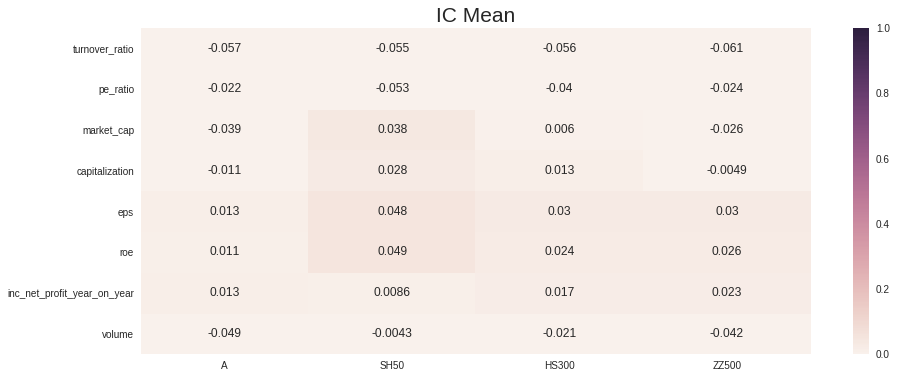

In [12]:
temp = pd.DataFrame()
temp['A'] = IC_A.mean()
temp['SH50'] = IC_SH50.mean()
temp['HS300'] = IC_HS300.mean()
temp['ZZ500'] = IC_ZZ500.mean()
fig.show()
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
sns.heatmap(temp, annot=True, vmax=1, vmin = 0)
ax.set_title("IC Mean", fontsize=21)
fig.show()


首先我们展示了全市场和三大股指中各因子 IC 的平均值，周平均 IC 值均在±1%以上，说明因子的解释力度都不错。其中，换手率的选股能力最强，其次为成交量因子，而股本因子效果在所有因子中最差。  
为了进一步分析因子的选股能力，本文对 IC 的波动性进行分析，下面我们展示了每个年度的 IC 均值。

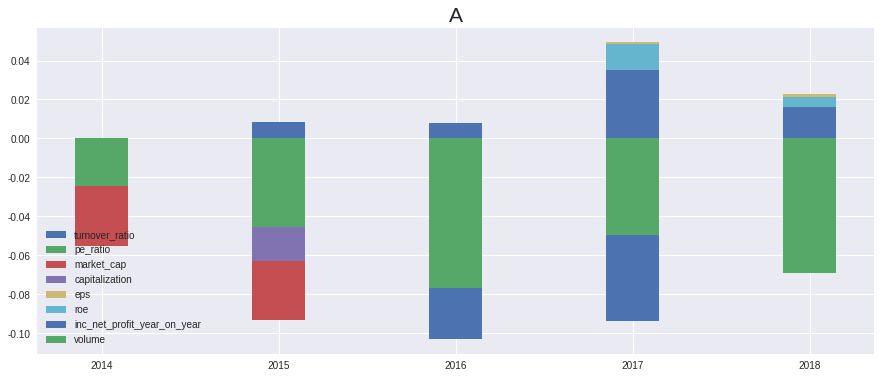

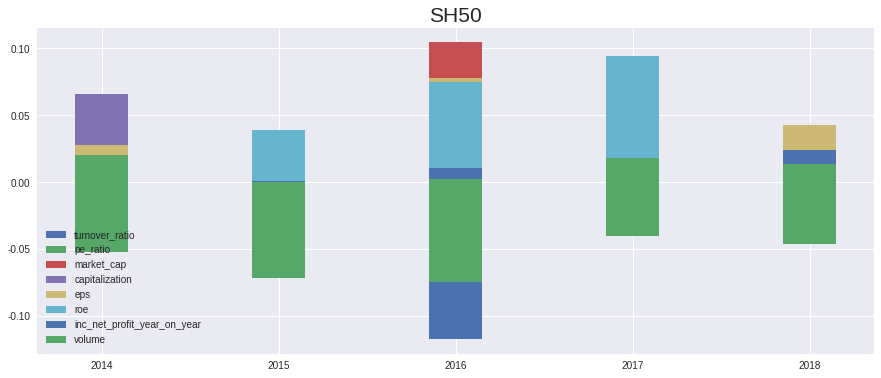

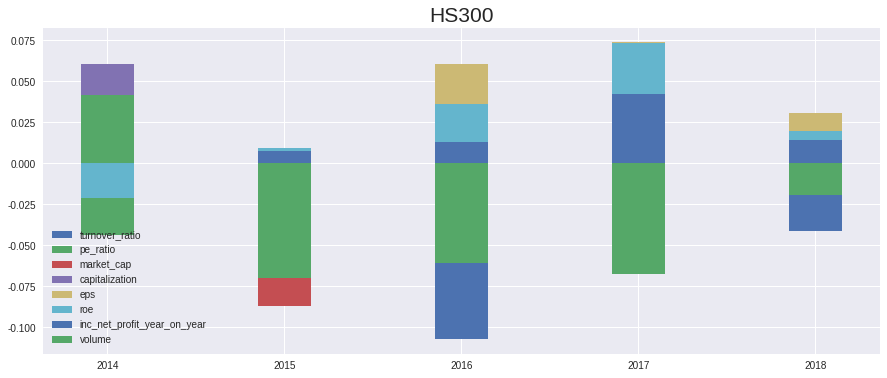

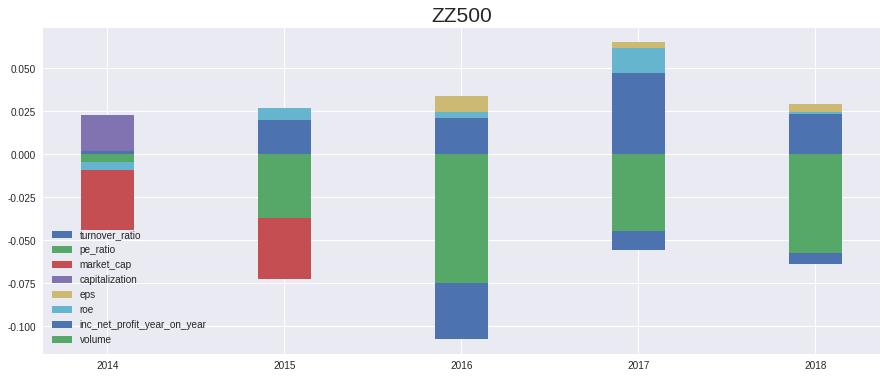

In [13]:
Year= ['2014', '2015', '2016', '2017', '2018']
Fields = ['turnover_ratio', 'pe_ratio', 'market_cap', 'capitalization', 'eps', 'roe', 'inc_net_profit_year_on_year', 'volume']
total1 = pd.DataFrame()
total2 = pd.DataFrame()
total3 = pd.DataFrame()
total4 = pd.DataFrame()
for i in range(len(Year)):
    total1[Year[i]] = IC_A.iloc[i*len(explore1)/5:(i+1)*len(explore1)/5,:].mean()
    total2[Year[i]] = IC_SH50.iloc[i*len(explore1)/5:(i+1)*len(explore1)/5,:].mean()
    total3[Year[i]] = IC_HS300.iloc[i*len(explore1)/5:(i+1)*len(explore1)/5,:].mean()
    total4[Year[i]] = IC_ZZ500.iloc[i*len(explore1)/5:(i+1)*len(explore1)/5,:].mean()
x = np.array(range(len(Year)))
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
for i in Fields:
    plt.bar(x, total1.loc[i], 0.3, label = i)
plt.xticks(range(len(Year)), Year)
ax.set_title("A", fontsize=21)
# 添加图例
plt.legend()
plt.show()
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
for i in Fields:
    plt.bar(x, total2.loc[i], 0.3, label = i)
plt.xticks(range(len(Year)), Year)
ax.set_title("SH50", fontsize=21)
# 添加图例
plt.legend()
plt.show()
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
for i in Fields:
    plt.bar(x, total3.loc[i], 0.3, label = i)
plt.xticks(range(len(Year)), Year)
ax.set_title("HS300", fontsize=21)
# 添加图例
plt.legend()
plt.show()
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
for i in Fields:
    plt.bar(x, total4.loc[i], 0.3, label = i)
plt.xticks(range(len(Year)), Year)
ax.set_title("ZZ500", fontsize=21)
# 添加图例
plt.legend()
plt.show()


上面我们对历史 IC 序列的每个年度均值进行分析，根据表中结果可以得到以下结论：  
（1）各个因子在上证 50 中的波动性最大，HS300 其次，紧接着是 ZZ500 与全市场；  
（2）换手率因子在各个指数成分股中的波动性最大，净利润增长率因子在各个指数成分股中波动性最小；  

## 4.2 IC 绝对值均值分析

为了考察绝对选股能力，我们在下表中展示了各因子 IC 的绝对值的平均值。

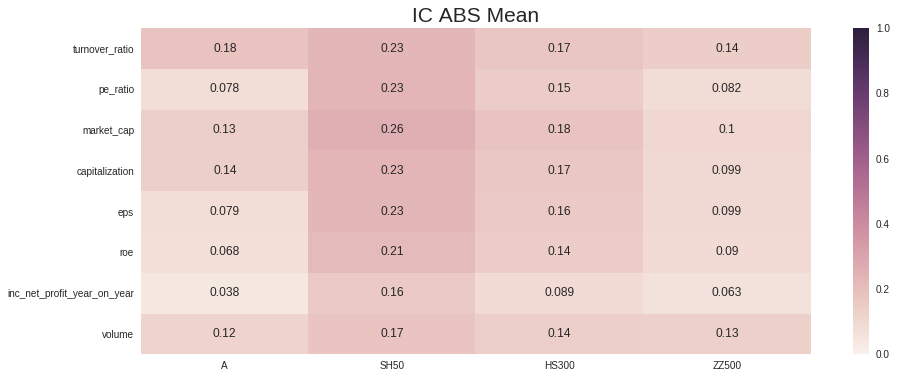

In [14]:
IC_A = abs(IC_A)
IC_SH50 = abs(IC_SH50)
IC_HS300 = abs(IC_HS300)
IC_ZZ500 = abs(IC_ZZ500)
temp = pd.DataFrame()
temp['A'] = IC_A.mean()
temp['SH50'] = IC_SH50.mean()
temp['HS300'] = IC_HS300.mean()
temp['ZZ500'] = IC_ZZ500.mean()
fig.show()
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
sns.heatmap(temp, annot=True, vmax=1, vmin = 0)
ax.set_title("IC ABS Mean", fontsize=21)
fig.show()


由上表可知，整体上可见 IC 的绝对值的平均值最高的是上证 50，其次是沪深 300，再次是中证 500。也就是说上证 50 指数的因子选股能力更加明显，但波动也较大。换手率因子在大部分指数中绝对值平均值最大，可见换手率因子的波动性最大，其次为市值因子，净利润增长率因子的绝对值平均值最小，该因子的波动性最小。由上可得到的结论与 IC 均值年度分析结果基本一致。  
接下来分年度展示了各因子 IC 的绝对值平均值。

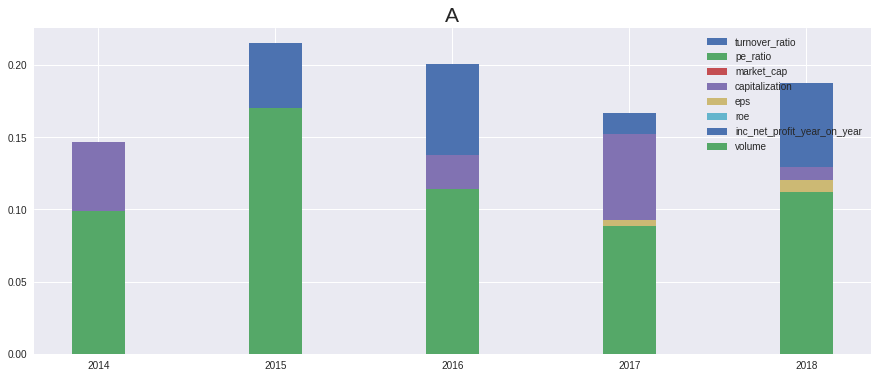

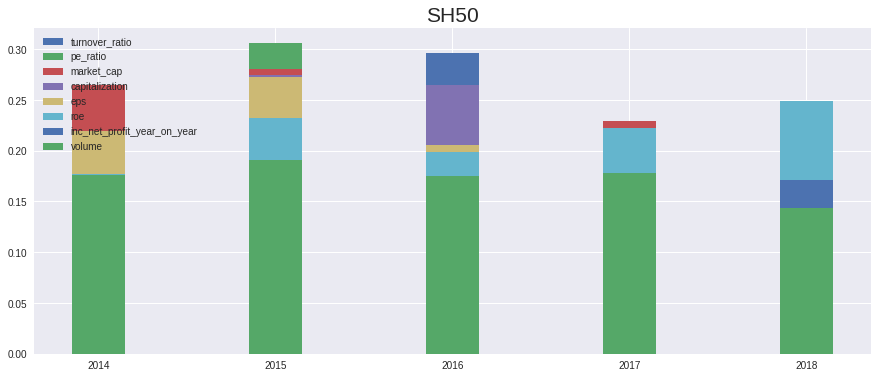

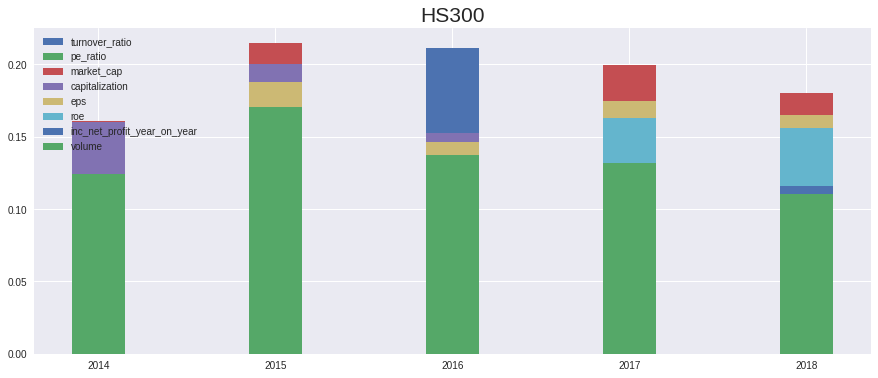

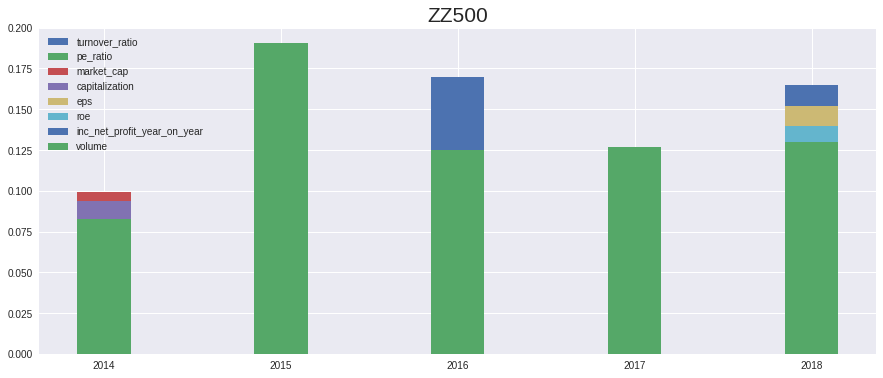

In [15]:
Year= ['2014', '2015', '2016', '2017', '2018']
Fields = ['turnover_ratio', 'pe_ratio', 'market_cap', 'capitalization', 'eps', 'roe', 'inc_net_profit_year_on_year', 'volume']
total1 = pd.DataFrame()
total2 = pd.DataFrame()
total3 = pd.DataFrame()
total4 = pd.DataFrame()
for i in range(len(Year)):
    total1[Year[i]] = IC_A.iloc[i*len(explore1)/5:(i+1)*len(explore1)/5,:].mean()
    total2[Year[i]] = IC_SH50.iloc[i*len(explore1)/5:(i+1)*len(explore1)/5,:].mean()
    total3[Year[i]] = IC_HS300.iloc[i*len(explore1)/5:(i+1)*len(explore1)/5,:].mean()
    total4[Year[i]] = IC_ZZ500.iloc[i*len(explore1)/5:(i+1)*len(explore1)/5,:].mean()
x = np.array(range(len(Year)))
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
for i in Fields:
    plt.bar(x, total1.loc[i], 0.3, label = i)
plt.xticks(range(len(Year)), Year)
ax.set_title("A", fontsize=21)
# 添加图例
plt.legend()
plt.show()
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
for i in Fields:
    plt.bar(x, total2.loc[i], 0.3, label = i)
plt.xticks(range(len(Year)), Year)
ax.set_title("SH50", fontsize=21)
# 添加图例
plt.legend()
plt.show()
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
for i in Fields:
    plt.bar(x, total3.loc[i], 0.3, label = i)
plt.xticks(range(len(Year)), Year)
ax.set_title("HS300", fontsize=21)
# 添加图例
plt.legend()
plt.show()
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
for i in Fields:
    plt.bar(x, total4.loc[i], 0.3, label = i)
plt.xticks(range(len(Year)), Year)
ax.set_title("ZZ500", fontsize=21)
# 添加图例
plt.legend()
plt.show()


由上表可知，除了换手率因子较强，净利润增长率较弱之外，其他因子的绝对的选股能力区别不大。

# 总结

前文所述，我们因子组合的评判标准分为三点: 因子暴露度、因子相关强度和因子选个股能力。以下为综上所得出的结论:  
（1）三大股指的市值和股本因子的偏离度均是最高的。中等偏离度的因子包括，换手率、 ROE、PE、EPS 因子。偏离度最小的是净利润增长率因子。  
（2）相关强度最低的组合为净利润增长率和成交量，换手率和 EPS，ROE 和换手率，股本 和换手率。  
（3）除了换手率因子较强，净利润增长率较弱之外，其他因子的选股能力区别不大。  
综合以上结论，可知综合选择暴露度高、相关强度低和选股能力强的因子，股本和换手率作为因子组合较为合适。